# Circulating CSF miRNA biomarker selection LGG vs HGG

## Author: Shehbeel Arif

## Purpose: To find a set of circulating miRNAs that are differential in Low-grade Glioma vs High-grade Gliomas in platient CSF biopsy samples.

---

## Load libraries

In [2]:
# Library for data handling
import numpy as np
import pandas as pd

# Library for performing RFE
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
#from sklearn.feature_selection import RFE

# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# Import Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

# Import sklearn library to assess model accuracy
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from statistics import mean, stdev


# Library for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from umap.umap_ import UMAP

## Data Preprocessing

In [15]:
# Load data
data_dir = '/Users/shehbeel/Documents/liquid-biopsy-analysis/data/'
meta = pd.read_csv(data_dir + 'lb_metadata.csv')
counts = pd.read_csv(data_dir + 'lb_csf_matrix.csv', index_col='gene')

# Select only CSF samples
meta = meta[meta['CSF_Specimen'] == True]

# Transpose counts
counts = counts.iloc[19:,]
counts = counts.T
counts = counts.reset_index()

# Merge counts and meta data
df = pd.merge(meta, counts, left_on='SDG_ID', right_on='index').drop(['index'], axis=1)

# Sanity check
df

,SDG_ID,CSF_Specimen,Plasma_Specimen,Diagnosis,Short_Histology,Tumor_Subtype,Relapse,Survival_Status,let-7a-2-3p,let-7a-3p,...,miR-944,miR-95-3p,miR-95-5p,miR-9-5p,miR-96-3p,miR-96-5p,miR-98-3p,miR-99a-5p,miR-99b-3p,miR-99b-5p
0,15635-37,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,Yes,Alive,121,48,...,9,182,83,594,0,22,34,5872,60,1015
1,15635-43,True,True,High-grade glioma/astrocytoma (WHO grade III/IV),HGG,DMG,Yes,Deceased,54,8,...,0,87,5,534,7,23,12,3231,50,483
2,15635-45,True,True,High-grade glioma/astrocytoma (WHO grade III/IV),HGG,DMG,Yes,Deceased,68,120,...,21,2353,44,1771,22,386,11,27367,203,2966
3,15635-46,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,No,Alive,128,38,...,0,31,34,120,0,30,44,1261,30,51
4,15635-60,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,No,Alive,632,363,...,79,226,199,1442,249,301,254,6233,342,1330
5,15635-68,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,No,Alive,233,63,...,0,131,57,764,0,34,29,8718,107,813
6,15635-80,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,No,Alive,41,10,...,1,47,13,668,0,85,10,25227,165,2333
7,15635-87,True,True,High-grade glioma/astrocytoma (WHO grade III/IV),HGG,DMG,Yes,Deceased,430,73,...,42,1059,56,24405,30,286,23,66214,811,5953
8,15635-100,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,Yes,Alive,193,51,...,14,210,54,652,0,9,62,7050,83,1101
9,15635-101,True,True,Low-grade glioma/astrocytoma (WHO grade I/II),LGG,pilocytic astrocytoma,No,Alive,401,96,...,0,87,74,51,0,49,76,2905,174,202


In [25]:
# Split the dataset into training data and labels
X = df.iloc[:,8:].values
y = df.loc[:, df.columns == 'Short_Histology'].values.ravel()

# Save feature names
features = df.iloc[:,8:].columns.to_list()

# Sanity check
print(X[:5])
print(y[:5])

[[  121    48  1023 ...  5872    60  1015]
 [   54     8  1014 ...  3231    50   483]
 [   68   120  6911 ... 27367   203  2966]
 [  128    38   955 ...  1261    30    51]
 [  632   363  3668 ...  6233   342  1330]]
['LGG' 'HGG' 'HGG' 'LGG' 'LGG']


---

## Visualize the data

/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Text(0, 0.5, 'UMAP2')

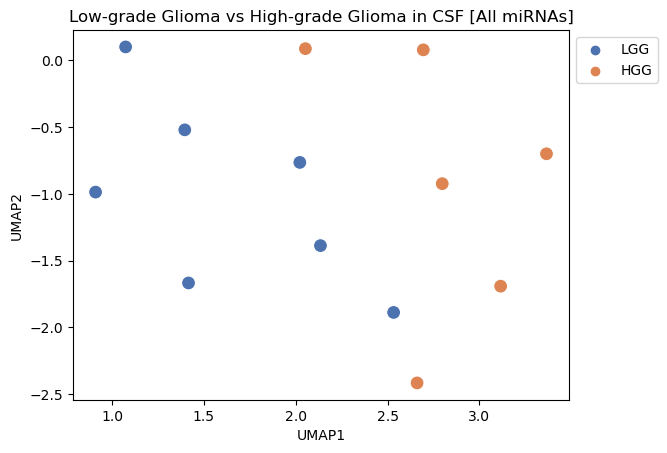

In [27]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(X)
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.Short_Histology, palette="deep", s=100)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Low-grade Glioma vs High-grade Glioma in CSF [All miRNAs]')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

---

## Random Forest (CV)

In [28]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
lst_accu_stratified = []

rfc = RandomForestClassifier(max_depth=3, random_state=123)

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    rfc.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(rfc.score(x_test_fold, y_test_fold))
  
# Print the output
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [1.0, 0.6666666666666666, 1.0, 0.5, 0.5]

Maximum Accuracy That can be obtained from this model is: 100.0 %

Minimum Accuracy: 50.0 %

Overall Accuracy: 73.33333333333333 %

Standard Deviation is: 0.25276251480171835


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

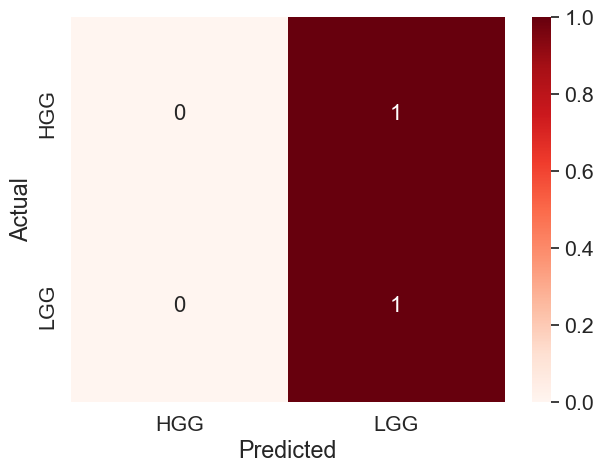

In [30]:
# Build confusion matrix
y_pred = rfc.predict(x_test_fold)
cm = confusion_matrix(y_test_fold, rfc.predict(x_test_fold))
cm = pd.DataFrame(cm, columns=np.unique(y_test_fold), index = np.unique(y_test_fold))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [31]:
# What are the most important features?
imp_features = pd.Series(rfc.feature_importances_, index=features)

imp_genes = imp_features.sort_values(ascending=False).to_frame().reset_index()
imp_genes.columns = ["features", "importance"]

rfc_imp_genes = imp_genes[~(imp_genes == 0.000000).any(axis=1)]
rfc_imp_genes

,features,importance
0,miR-6069,0.030000
1,miR-6885-5p,0.020000
2,miR-4725-3p,0.020000
3,miR-3912-3p,0.020000
4,miR-374c-5p,0.020000
...,...,...
89,miR-339-5p,0.010000
90,miR-6821-3p,0.006944
91,miR-3182,0.005926
92,miR-556-3p,0.004074


/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Text(0, 0.5, 'UMAP2')

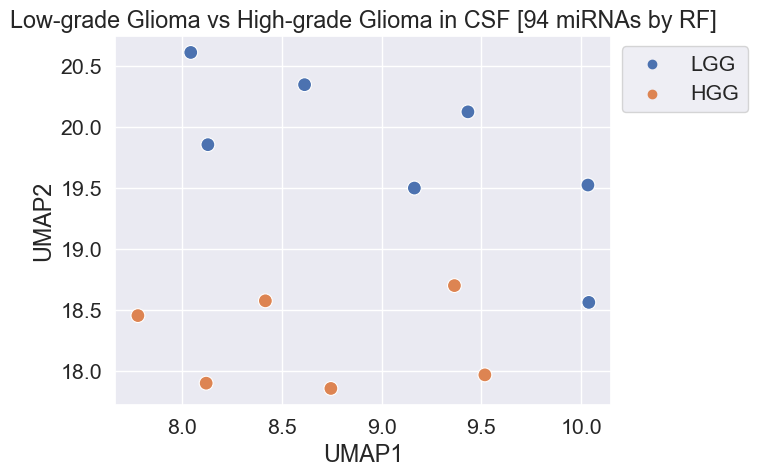

In [32]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df[rfc_imp_genes.features.to_list()])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.Short_Histology, palette="deep", s=100)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Low-grade Glioma vs High-grade Glioma in CSF [94 miRNAs by RF]')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

---

## Logistic Regression (CV)

In [33]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
lst_accu_stratified = []

lr = LogisticRegression(max_iter=40, random_state=123)

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    lr.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(rfc.score(x_test_fold, y_test_fold))
  
# Print the output
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [1.0, 1.0, 1.0, 1.0, 0.5]

Maximum Accuracy That can be obtained from this model is: 100.0 %

Minimum Accuracy: 50.0 %

Overall Accuracy: 90.0 %

Standard Deviation is: 0.22360679774997896


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

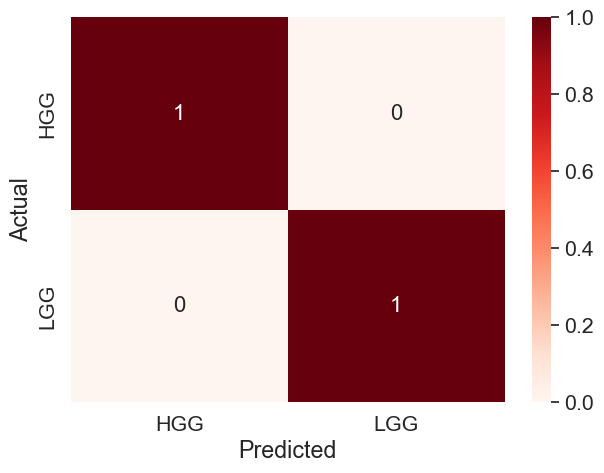

In [34]:
# Build confusion matrix
y_pred = rfc.predict(x_test_fold)
cm = confusion_matrix(y_test_fold, lr.predict(x_test_fold))
cm = pd.DataFrame(cm, columns=np.unique(y_test_fold), index = np.unique(y_test_fold))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [36]:
# What are the most important features?
imp_features = pd.Series(lr.coef_[0], index=features)

imp_genes = imp_features.sort_values(ascending=False).to_frame().reset_index()
imp_genes.columns = ["features", "importance"]

#imp_genes_fil = imp_genes[(imp_genes.importance > 0.00001) | (imp_genes.importance < -0.00001)]
imp_genes_fil = imp_genes.iloc[imp_genes['importance'].abs().argsort()].reset_index(drop=True)
lr_genes_100 = imp_genes_fil.tail(100)
lr_genes_100

,features,importance
1983,miR-26a-5p,0.000002
1984,miR-4763-3p,0.000002
1985,miR-148a-3p,0.000002
1986,miR-6778-5p,0.000002
1987,miR-4706,0.000002
...,...,...
2078,miR-6803-5p,0.000038
2079,miR-6126,-0.000045
2080,miR-6727-5p,0.000046
2081,miR-1237-5p,0.000070


/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Text(0, 0.5, 'UMAP2')

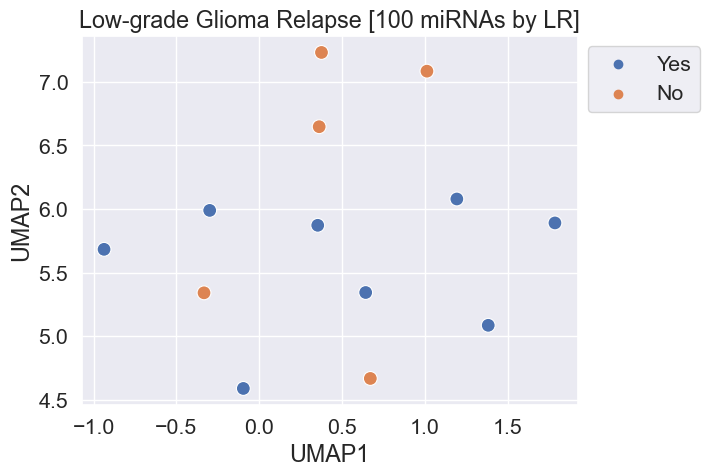

In [37]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df[lr_genes_100['features'].to_list()])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.Relapse, palette="deep", s=100)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Low-grade Glioma Relapse [100 miRNAs by LR]')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [38]:
mirna_intersected = list(set(rfc_imp_genes.features.to_list()) & set(lr_genes_100.features.to_list()))
mirna_intersected

['miR-6798-5p',
 'miR-6892-3p',
 'miR-339-3p',
 'miR-541-3p',
 'miR-143-3p',
 'miR-4291',
 'miR-3943',
 'miR-6825-3p',
 'miR-3157-5p',
 'miR-6852-3p',
 'miR-561-3p']

/Users/shehbeel/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


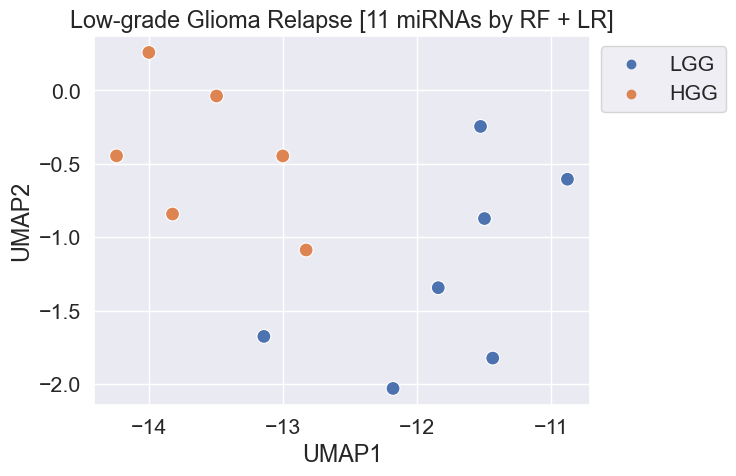

In [39]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df[mirna_intersected])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.Short_Histology, palette="deep", s=100)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Low-grade Glioma Relapse [11 miRNAs by RF + LR]')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.show()

---